### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('../modules')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time

from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
# s3_path = 'nneehal/DATA/odata/m6_knn_no_cluster_only_latent'
# data_path = '../temp'

# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/{s3_path} {data_path} --recursive;

In [5]:
%%time
p = '../temp/odata_knn/'
treated = pd.read_pickle(p+'treated0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 229 ms, sys: 103 ms, total: 332 ms
Wall time: 349 ms


In [6]:
### Optional(filter registrations after  a particular month and before a particular month)

In [7]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 201711
    month_filter_upper = 202008
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [8]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}


kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [9]:
path_tabs = '../res/tabs/'
path_figs = '../res/figs/'
path_figs2 = '../res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [10]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Line of Bussiness', 'Treatment']

In [11]:
treated = treated.rename(columns={"MEDICAID_LOB":"LOB"})
controls = controls.rename(columns={"MEDICAID_LOB":"LOB"})

### Diabetes

In [12]:
%%time
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)


CPU times: user 13.4 s, sys: 90.9 ms, total: 13.5 s
Wall time: 13.5 s


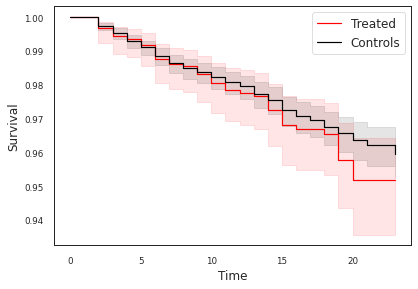

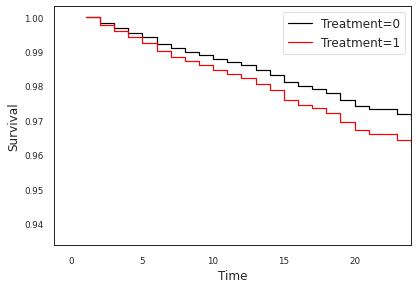

In [13]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [14]:
lrsumm

test_statistic         p  -log2(p)
Diabetes        0.965676  0.325761  1.618115

In [15]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                      1.607           0.400        4.022    0.000
Gender                   0.390           0.133        2.946    0.003
Total Cost               0.223           0.094        2.367    0.018
Tobacco use              0.262           0.250        1.051    0.293
Obesity                  0.521           0.140        3.718    0.000
Hypertension             0.018           0.161        0.113    0.910
Hypothyroid             -0.120           0.267       -0.449    0.653
Disease Count           -1.014           0.706       -1.436    0.151
Line of Bussiness       -0.581           0.194       -3.000    0.003
Treatment                0.242           0.158        1.530    0.126

### ER

In [16]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [17]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 13.5 s, sys: 52.9 ms, total: 13.6 s
Wall time: 13.6 s


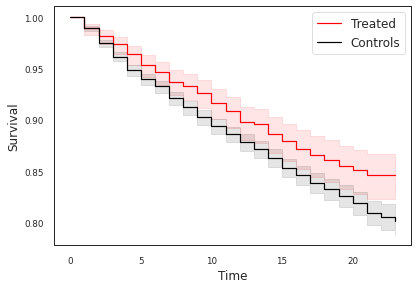

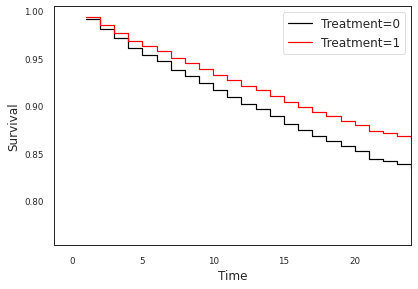

In [18]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'ER'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [19]:
lrsumm

test_statistic         p  -log2(p)
ER        8.522546  0.003508  8.155245

In [20]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.425           0.172       -8.272    0.000
Gender                  -0.081           0.065       -1.240    0.215
Total Cost               0.122           0.043        2.858    0.004
Tobacco use              0.363           0.095        3.836    0.000
Obesity                 -0.058           0.063       -0.923    0.356
Hypertension             0.214           0.074        2.888    0.004
Hypothyroid             -0.295           0.117       -2.516    0.012
Disease Count            1.993           0.276        7.229    0.000
Line of Bussiness       -0.858           0.074      -11.666    0.000
Treatment               -0.223           0.080       -2.776    0.006

### IP

In [21]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [22]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 13.7 s, sys: 15.1 ms, total: 13.7 s
Wall time: 13.7 s


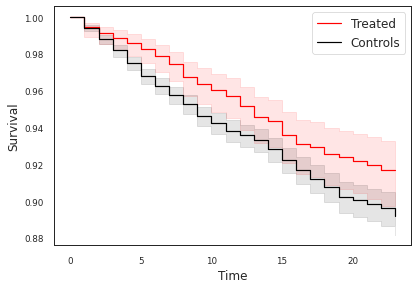

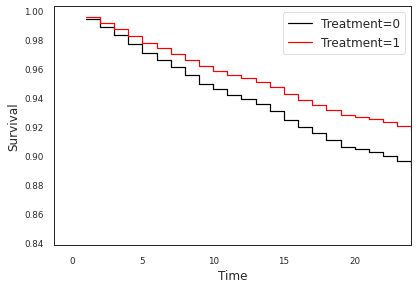

In [23]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'IP'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [24]:
ax1.collections[0].set

<bound method Artist.set of <matplotlib.collections.PolyCollection object at 0x7f1d526ce630>>

In [25]:
lrsumm

test_statistic         p  -log2(p)
IP        5.685691  0.017104  5.869539

In [26]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.439           0.231       -6.224    0.000
Gender                  -0.114           0.088       -1.297    0.195
Total Cost               0.346           0.064        5.400    0.000
Tobacco use              0.317           0.128        2.480    0.013
Obesity                 -0.205           0.085       -2.412    0.016
Hypertension             0.198           0.100        1.993    0.046
Hypothyroid             -0.454           0.164       -2.762    0.006
Disease Count            2.482           0.347        7.151    0.000
Line of Bussiness       -0.365           0.106       -3.438    0.001
Treatment               -0.278           0.109       -2.542    0.011

### Acute Care IP OR ER

In [27]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [28]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 13.5 s, sys: 14.7 ms, total: 13.6 s
Wall time: 13.6 s


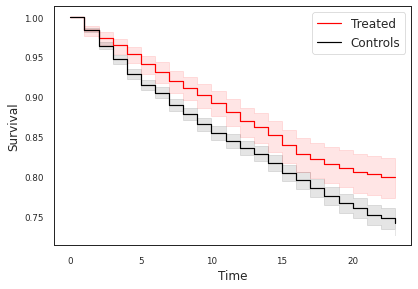

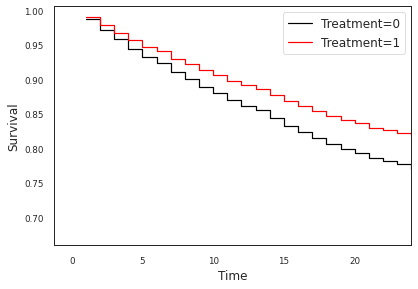

In [29]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline)

In [30]:
lrsumm

test_statistic         p   -log2(p)
Acute       12.614414  0.000383  11.351184

In [31]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.432           0.150       -9.577    0.000
Gender                  -0.090           0.056       -1.607    0.108
Total Cost               0.184           0.038        4.899    0.000
Tobacco use              0.371           0.084        4.444    0.000
Obesity                 -0.071           0.055       -1.306    0.192
Hypertension             0.249           0.064        3.897    0.000
Hypothyroid             -0.340           0.103       -3.308    0.001
Disease Count            2.039           0.240        8.503    0.000
Line of Bussiness       -0.725           0.066      -11.053    0.000
Treatment               -0.257           0.070       -3.689    0.000

### Load all Log Rank Sums in a matrix

In [32]:
from pathlib import Path
p = Path('../res/tabs')

df2 = None
for i, ff in enumerate(p.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)



df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['logRank statistic', 'p-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care']
df2['RMST difference'] = np.array([rmstD, rmstER, rmstIP, rmstAcute])
df2.round(3).to_csv('../res/tabs/all_logrank.csv')


In [33]:
df2

logRank statistic   p-value  RMST difference
Diabetes                   0.965676  0.325761        -0.072323
Emergency Visits           8.522546  0.003508         0.525650
Inpatient Vistis           5.685691  0.017104         0.353310
Acute Care                12.614414  0.000383         0.773587